In [15]:
import numpy as np
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorboard
from sklearn.metrics import accuracy_score
import tensorflow as tf

### Reading the data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# нормализация.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Добавляем размер канала для изображения.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


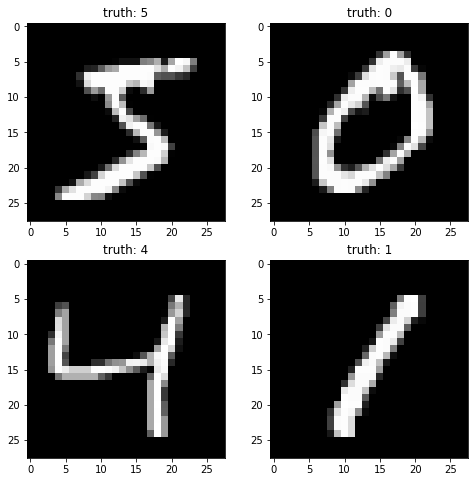

In [3]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title('truth: {}'.format(y_train[i]))

### Params tuning

В качестве гиперпараметров были выбраны 2 типа модели (многослойный перцептрон и сверточная сеть), количество слоев, фильтров, Dropout

In [4]:
def build_model(hp):
    inputs = keras.Input(shape=(28, 28, 1))
    # Тип модели - MLP или CNN.
    model_type = hp.Choice("model_type", ["mlp", "cnn"])
    x = inputs
    if model_type == "mlp":
        x = layers.Flatten()(x)
        # Гиперпараметр - Число слоев MLP.
        for i in range(hp.Int("mlp_layers", 1, 3)):
            # Число фильтров для каждого слоя
            output_node = layers.Dense(
                units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
            )(x)
    else:
        # Гиперпараметр - Число слоев CNN.
        for i in range(hp.Int("cnn_layers", 1, 3)):
            x = layers.Conv2D(
                hp.Int(f"filters_{i}", 32, 128, step=32),
                kernel_size=(3, 3),
                activation="relu",
            )(x)
            x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Flatten()(x)

    # Гиперпараметр - используется или нет dropout.
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(units=10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Компиляция модели.
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam",
    )
    return model

In [5]:
hp = keras_tuner.HyperParameters()
hp.values["model_type"] = "cnn"

model = build_model(hp)

model(x_train[:100])

model.summary()


hp.values["model_type"] = "mlp"
model = build_model(hp)
model(x_train[:100])
model.summary()

2022-05-11 05:17:02.567690: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-11 05:17:02.578809: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 05:17:02.618107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shap

In [6]:
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=10,

    overwrite=True,
    objective="val_accuracy",
  
    directory="/tmp/tb",
)

In [7]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=2,
 
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 10 Complete [00h 05m 47s]
val_accuracy: 0.9863333106040955

Best val_accuracy So Far: 0.9863333106040955
Total elapsed time: 00h 24m 38s
INFO:tensorflow:Oracle triggered exit


In [8]:
tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 2
units_0: 128
dropout: True
cnn_layers: 2
filters_0: 96
filters_1: 64
units_1: 128
filters_2: 64
Score: 0.9863333106040955
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 3
units_0: 64
dropout: False
cnn_layers: 2
filters_0: 96
filters_1: 64
Score: 0.984666645526886
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 2
units_0: 96
dropout: False
cnn_layers: 2
filters_0: 32
filters_1: 32
Score: 0.9838333129882812
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 3
units_0: 64
dropout: False
cnn_layers: 3
filters_0: 64
filters_1: 64
units_1: 96
filters_2: 32
Score: 0.9787499904632568
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 3
units_0: 64
dropout: True
cnn_layers: 1
filters_0: 64
filters_1: 96
units_1: 128
filters_2: 96
Score: 0.9775000214576721
Trial summary
Hyperparameters:
model_type: cnn
mlp_layers: 2
units_

### Learning Curves

In [9]:
#!pip3 install --upgrade tensorboard

In [10]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

### Prediction

In [12]:
best_hps = tuner.get_best_hyperparameters(2)
model = build_model(best_hps[0])

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

model.fit(train_dataset, epochs=10)

print('\n# Оценка')
model.evaluate(test_dataset)

Epoch 1/10
938/938 [==============================] - 171s 182ms/step - loss: 0.5080 - accuracy: 0.8469
Epoch 2/10
938/938 [==============================] - 178s 190ms/step - loss: 0.0876 - accuracy: 0.9732
Epoch 3/10
938/938 [==============================] - 165s 175ms/step - loss: 0.0690 - accuracy: 0.9783
Epoch 4/10
938/938 [==============================] - 167s 178ms/step - loss: 0.0557 - accuracy: 0.9828
Epoch 5/10
938/938 [==============================] - 160s 171ms/step - loss: 0.0515 - accuracy: 0.9841
Epoch 6/10
938/938 [==============================] - 161s 172ms/step - loss: 0.0440 - accuracy: 0.9862
Epoch 7/10
938/938 [==============================] - 159s 169ms/step - loss: 0.0411 - accuracy: 0.9872
Epoch 8/10
938/938 [==============================] - 163s 174ms/step - loss: 0.0381 - accuracy: 0.9883
Epoch 9/10
938/938 [==============================] - 157s 167ms/step - loss: 0.0352 - accuracy: 0.9887
Epoch 10/10
938/938 [==============================] - 159s 169m

[0.023576563224196434, 0.9922999739646912]